In [1]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt



In [29]:
num_worker=os.cpu_count()
device='cuda:0' if torch.cuda.is_available() else 'cpu'

In [30]:
device,num_worker

('cuda:0', 12)

In [31]:
manual_transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
])

In [32]:
minist_trainset = MNIST(root='./data',train=True,transform=manual_transform)

In [33]:
train_dataloader=DataLoader(minist_trainset,batch_size=5)

In [34]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [36]:
# Generate Fake Data: output like real data [1, 28, 28] and values 0, 1 because To_Tensor mam
class Generator(nn.Module):
    def __init__(self, latent_dim:int=100):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
        self.sign =nn.Sigmoid()

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [37]:
class GAN(nn.Module):
    def __init__(self,gen:nn.Module,dis:nn.Module,latent_dim:int=100,lr:float=0.0002):
        super().__init__()
        self.latent_dim=latent_dim
        self.lr=lr
        self.generator = gen
        self.discrim   = dis
        
        self.validation_z = torch.randn(6,self.latent_dim)
        
    def forward(self,x):
        return self.discrim(self.generator(x))
    
    def aversarial_loss(self,y,y_label):
        return F.binary_cross_entropy(y,y_label)
    
    def create_optimizer(self):
        lr=self.lr
        opt_gen=torch.optim.Adam(self.generator.parameters(),lr=lr)
        opt_dis=torch.optim.Adam(self.discrim.parameters(),lr=lr)
        return opt_gen,opt_dis
    
    def validation_image(self):
        z=self.validation_z.type_as(self.generator.lin1.weight)
        with torch.no_grad():
            sample_img=self.generator(z).cpu()
        
        print(sample_img.size())
        
        fig=plt.figure()
        
        plt.title('Generated data')
        for i in range(sample_img.size()[0]):
            plt.subplot(2,3,i+1)
            plt.imshow(sample_img.detach()[i,0,:,:],cmap='gray_r',interpolation='none')
            plt.axis('off')
        
        plt.show()

In [38]:
Discrim=Discriminator().to(device)
Gener=Generator().to(device)
gan=GAN(Gener,Discrim).to(device)

In [40]:
opt_gen,opt_dis=gan.create_optimizer()

In [41]:
from tqdm import tqdm

In [42]:
def train(gan:GAN,dis:Discriminator,gen:Generator,opt_gen,opt_dis,dataloader,batch=5,epoch=10,latent_dim=100):
    for i in range(epoch):
        for data,_ in tqdm(dataloader):
            latent=torch.randn(batch,latent_dim).to(device)
            data=data.to(device)
            
            fake_images = gen(latent)  #fake image
            
            fake_label  = torch.zeros(batch,1).type_as(data).to(device) #true
            real_label  = torch.ones(batch,1).type_as(data).to(device) #true
            
            # training discriminator first
            dis.train()
            
            pre_fake_image=dis(fake_images)
            pre_real_image=dis(data)
            
            opt_dis.zero_grad()
            
            loss_dis =F.binary_cross_entropy(pre_fake_image,fake_label) + F.binary_cross_entropy(pre_real_image,real_label)
            
            loss_dis.backward()
            
            opt_dis.step() #-> update dis not affect gen
            
            # training generator maxmimize loss
            gen.train()
            
            latent=torch.randn(batch,latent_dim).to(device)
            
            pre=gan(latent) # fake image
            
            opt_gen.zero_grad() 
            
            loss_gen = F.binary_cross_entropy(pre,real_label)
            
            loss_gen.backward()
            
            opt_gen.step() # update gen not affect dist
            
        print('#'*20)
        print('Finish Epoch{}/{}'.format(i+1,epoch))
        gan.validation_image()
            

100%|██████████| 12000/12000 [03:14<00:00, 61.76it/s]


####################
Finish Epoch1/10
torch.Size([6, 1, 28, 28])


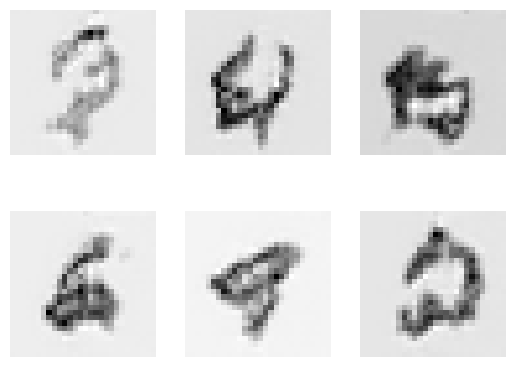

100%|██████████| 12000/12000 [03:09<00:00, 63.35it/s]


####################
Finish Epoch2/10
torch.Size([6, 1, 28, 28])


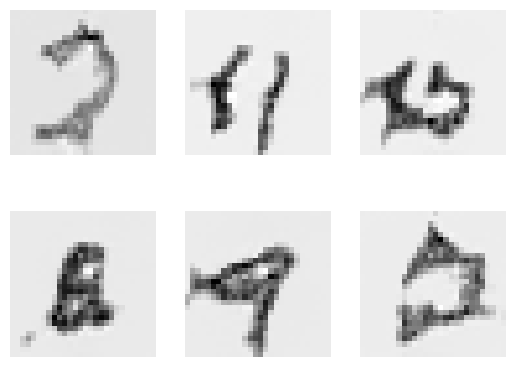

100%|██████████| 12000/12000 [03:11<00:00, 62.78it/s]


####################
Finish Epoch3/10
torch.Size([6, 1, 28, 28])


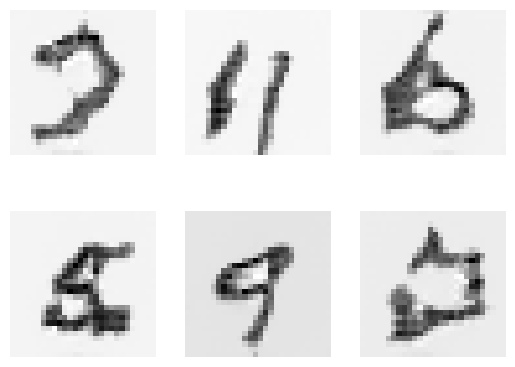

100%|██████████| 12000/12000 [03:04<00:00, 64.97it/s]


####################
Finish Epoch4/10
torch.Size([6, 1, 28, 28])


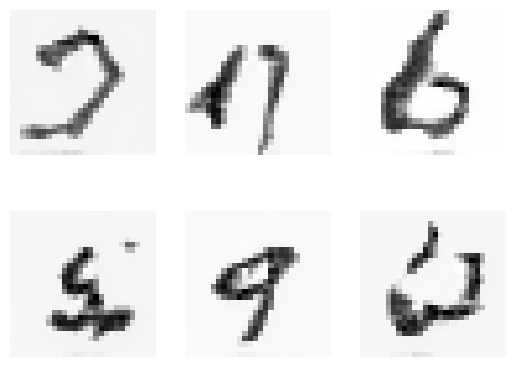

100%|██████████| 12000/12000 [03:12<00:00, 62.33it/s]


####################
Finish Epoch5/10
torch.Size([6, 1, 28, 28])


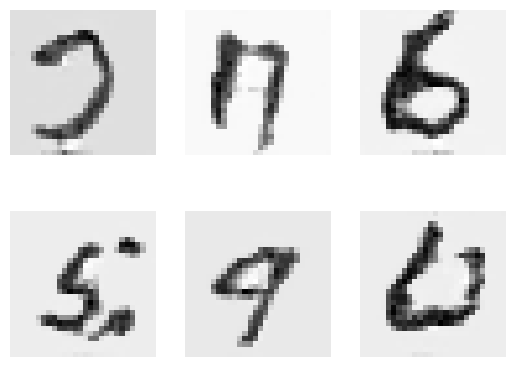

100%|██████████| 12000/12000 [03:05<00:00, 64.80it/s]


####################
Finish Epoch6/10
torch.Size([6, 1, 28, 28])


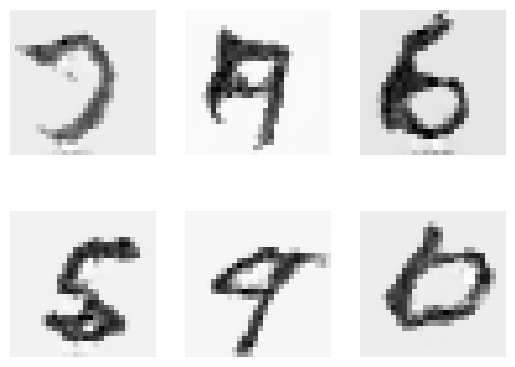

100%|██████████| 12000/12000 [03:12<00:00, 62.19it/s]


####################
Finish Epoch7/10
torch.Size([6, 1, 28, 28])


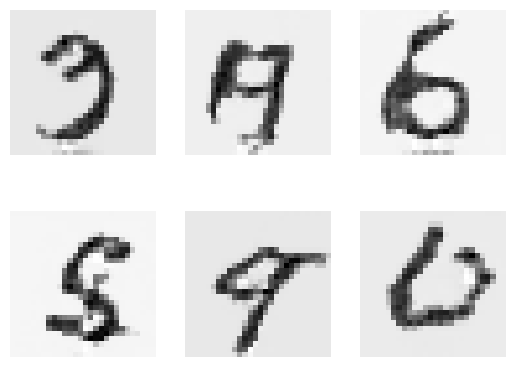

100%|██████████| 12000/12000 [03:06<00:00, 64.51it/s]


####################
Finish Epoch8/10
torch.Size([6, 1, 28, 28])


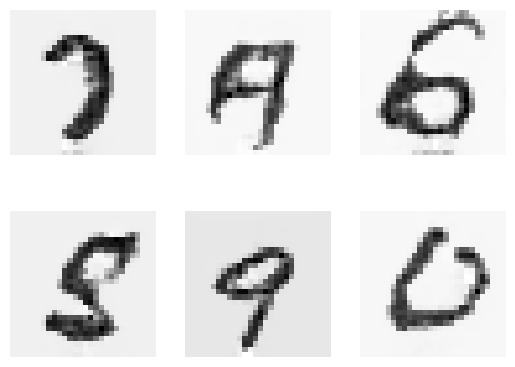

100%|██████████| 12000/12000 [03:11<00:00, 62.74it/s]


####################
Finish Epoch9/10
torch.Size([6, 1, 28, 28])


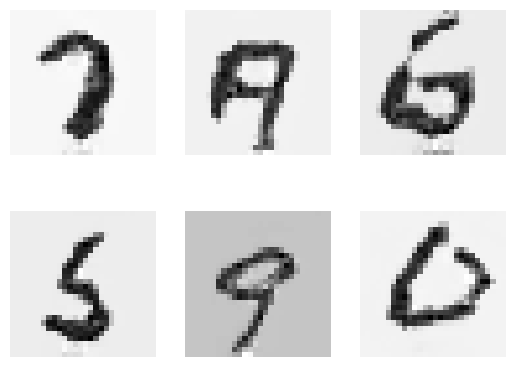

100%|██████████| 12000/12000 [03:26<00:00, 58.25it/s]


####################
Finish Epoch10/10
torch.Size([6, 1, 28, 28])


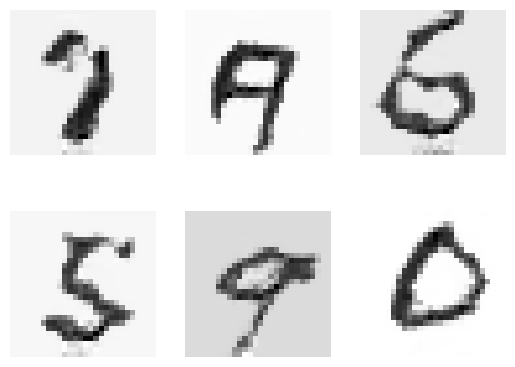

In [43]:
train(gan,Discrim,Gener,opt_gen,opt_dis,train_dataloader)